<a href="https://colab.research.google.com/github/johneliot1978/neural-networks/blob/main/PyTorchTesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#blog post https://medium.com/dair-ai/pytorch-1-2-quickstart-with-google-colab-6690a30c38d

#install prereqs locally
pip3 install torch torchvision -f https://download.pytorch.org/whl/torch_stable.html
pip install matplotlib
pip install numpy
pip install tqdm

# start local jupiter notebook: jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0

# choose local connection in colaborate and paste in local url from cmd line and token to connect.



In [46]:
#imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [3]:
#check local gpu connection
torch.cuda.get_device_name(0)


'NVIDIA GeForce GTX 1080'

In [41]:
#import data
#if you get timeout errors below in the "check the dimmensions of a batch" setp, set num_workers=0
BATCH_SIZE = 32

## transformations
transform = transforms.Compose(
    [transforms.ToTensor()])

## download and load training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=1)

## download and load testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=1)

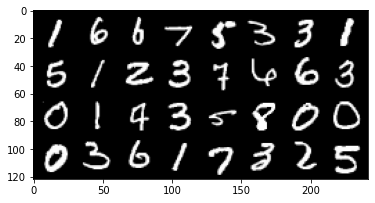

In [42]:
#check some of the data (random)

## functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

## get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

## show images
imshow(torchvision.utils.make_grid(images))

In [43]:
#check the dimmensions of a batch

for images, labels in trainloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

Image batch dimensions: torch.Size([32, 1, 28, 28])
Image label dimensions: torch.Size([32])


In [18]:
#define the model

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        # 28x28x1 => 26x26x32
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.d1 = nn.Linear(26 * 26 * 32, 128)
        self.d2 = nn.Linear(128, 10)

    def forward(self, x):
        # 32x1x28x28 => 32x32x26x26
        x = self.conv1(x)
        x = F.relu(x)

        # flatten => 32 x (32*26*26)
        x = x.flatten(start_dim = 1)

        # 32 x (32*26*26) => 32x128
        x = self.d1(x)
        x = F.relu(x)

        # logits => 32x10
        logits = self.d2(x)
        out = F.softmax(logits, dim=1)
        return out

In [19]:
## test the model with 1 batch
model = MyModel()
for images, labels in trainloader:
    print("batch size:", images.shape)
    out = model(images)
    print(out.shape)
    break

batch size: torch.Size([32, 1, 28, 28])
torch.Size([32, 10])


In [20]:
#define how to train the model
learning_rate = 0.001
num_epochs = 5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MyModel()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## compute accuracy
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [54]:
#do the training (each time it's run it starts with the previous model knowledge and improves)
#for epoch in range(num_epochs):
for i in tqdm(range(num_epochs)):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()

    ## training step
    for i, (images, labels) in enumerate(trainloader):
        
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)
    
    model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / i, train_acc/i)) 

 20%|████████████████▊                                                                   | 1/5 [00:09<00:37,  9.49s/it]

Epoch: 4 | Loss: 1.4653 | Train Accuracy: 99.72


 40%|█████████████████████████████████▌                                                  | 2/5 [00:20<00:30, 10.17s/it]

Epoch: 4 | Loss: 1.4653 | Train Accuracy: 99.72


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:31<00:21, 10.54s/it]

Epoch: 4 | Loss: 1.4652 | Train Accuracy: 99.73


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:41<00:10, 10.28s/it]

Epoch: 4 | Loss: 1.4649 | Train Accuracy: 99.76


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:52<00:00, 10.52s/it]

Epoch: 4 | Loss: 1.4652 | Train Accuracy: 99.73


In [55]:
#testaccuracy of training
test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 98.54
